In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
import time
import itertools
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [2]:
from numpy.random import seed
seed(1)

In [3]:
#df_bin = pd.read_csv('data/7Mfinal_balanced_bin_filter_scaf.csv')
df = pd.read_csv('data/final_data.csv')

In [4]:
Q1 = df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.25)
Q3 = df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']].quantile(0.75)
IQR = Q3 - Q1
df_drop_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape, df_drop_out.shape

/var/tmp/pbs.45885.lich-compute.vscht.cz/ipykernel_4046/3154387766.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_drop_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


((18176, 9), (16598, 9))

In [6]:
df_bin = df_drop_out

In [7]:
df_bin['steps_bins'] = pd.cut(df_bin['number_of_steps'], [0,1,3,6,10], labels=False)
df_bin.steps_bins.value_counts()

1    5376
0    4905
2    3386
3    2931
Name: steps_bins, dtype: int64

In [8]:
y_bin = np.array(df_bin.steps_bins).ravel()
y_ste = np.array(df_bin.number_of_steps).ravel()
x = np.array(df_bin[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors']])
x = StandardScaler().fit_transform(x)

In [9]:
#x = StandardScaler().fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size=0.25, random_state=1)
X_train_ste, X_test_ste, y_train_ste, y_test_ste = train_test_split(x, y_ste, test_size=0.25, random_state=1)

In [10]:
def cross_scoring(model, X, Y):
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=10)
    return scores

In [11]:
def vizualization_metrics(df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.tight_layout(pad=5.0)
    #sns.barplot(ax=axes[0,0], data=df, x="model", y="test_r2")
    #axes[0,0].set_title('R2')
    sns.barplot(ax=axes[0], data=df, x="model", y="test_MAE")
    axes[0].set_title('MAE')
    sns.barplot(ax=axes[1], data=df, x="model", y="test_MSE")
    axes[1].set_title('MSE')
    #sns.barplot(ax=axes[1,1], data=df, x="model", y="test_RMSE")
    #axes[1,1].set_title('RMSE')

In [12]:
def return_std(results):
    model_std =  np.array(results.cv_results_['std_test_score']) 
    model_mse =  np.array((-1)*results.cv_results_['mean_test_score'])
    std = 0
    for i in range(len(model_mse)):
        if model_mse[i] + results.best_score_ == 0:
            std = model_std[i]
    print('Best STD: %0.4f' % std)
    return std

def return_round_predict(model, X_train, y_train, X_test, limit):
    model_fit = model.fit(X_train, y_train)
    predict = model_fit.predict(X_test)
    predict_r = np.array([round(y) for y in predict])
    for i in range(len(predict_r)):
        if predict_r[i] > limit:
            predict_r[i] = limit
    return predict_r  

In [13]:
#models = ['RFR','XGB','SVR','KNR']
names = ['KNR','RFR', 'SVR','XGB','MLP']
RFR = RandomForestRegressor(random_state=0)
XGB = xgb.XGBRegressor(seed=0)
SV = SVR()
KNR = KNeighborsRegressor()
MLP = MLPRegressor(random_state=0, max_iter=1000)

### Groups

In [14]:
score_RFR = cross_scoring(RFR, x, y_bin)
score_XGB = cross_scoring(XGB, x, y_bin)
score_SVR = cross_scoring(SV, x, y_bin)
score_KNR = cross_scoring(KNR, x, y_bin)
score_MLP = cross_scoring(MLP, x, y_bin)

In [15]:
d1 = pd.DataFrame.from_dict(score_RFR)
d1['model']='RFR'
d2 = pd.DataFrame.from_dict(score_XGB)
d2['model']='XGB'
d3 = pd.DataFrame.from_dict(score_SVR)
d3['model']='SVR'
d4 = pd.DataFrame.from_dict(score_KNR)
d4['model']='KNR'
d5 = pd.DataFrame.from_dict(score_MLP)
d5['model']='MLP'

In [16]:
frames = [d1,d2,d3,d4,d5]
df_scores = pd.concat(frames)

In [17]:
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']
df_scores['test_RMSE'] = -1*df_scores['test_RMSE']

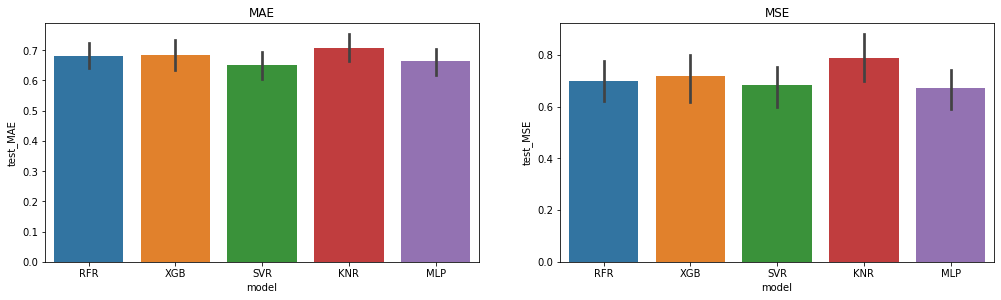

In [18]:
vizualization_metrics(df_scores)

In [46]:
bases_all = [('KNR',KNR), ('RFR',RFR), ('SVR',SV), ('XGB',XGB)] #, ('MLP',MLP)
mse_models = []
std_models = []
for base in bases_all:
    print(base[0])
    cross_model = cross_val_score(base[1], x, y_bin, scoring='neg_mean_squared_error', cv=10)
    print("MSE: %0.3f, STD: %0.3f" % (-cross_model.mean(), cross_model.std()))
    mse_models.append(-cross_model.mean())
    std_models.append(cross_model.std())

KNR
MSE: 0.789, STD: 0.146
RFR
MSE: 0.700, STD: 0.134
SVR
MSE: 0.685, STD: 0.128
XGB
MSE: 0.717, STD: 0.147


In [47]:
MSE_models_no_opt = pd.DataFrame(zip(names, mse_models, std_models), columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models_no_opt

,MODEL,MSE,STD
2,SVR,0.685232,0.127521
1,RFR,0.699929,0.134300
3,XGB,0.717096,0.147209
0,KNR,0.789261,0.145815


In [48]:
MSE_models_no_opt.to_csv('df_models_out.txt', index=None, sep=' ', mode='a')

### Steps

In [23]:
score_RFR_ste = cross_scoring(RFR, x, y_ste)
score_XGB_ste = cross_scoring(XGB, x, y_ste)
score_SVR_ste = cross_scoring(SV, x, y_ste)
score_KNR_ste = cross_scoring(KNR, x, y_ste)
score_MLP_ste = cross_scoring(MLP, x, y_ste)

In [24]:
d1 = pd.DataFrame.from_dict(score_RFR_ste)
d1['model']='RFR'
d2 = pd.DataFrame.from_dict(score_XGB_ste)
d2['model']='XGB'
d3 = pd.DataFrame.from_dict(score_SVR_ste)
d3['model']='SVR'
d4 = pd.DataFrame.from_dict(score_KNR_ste)
d4['model']='KNR'
d5 = pd.DataFrame.from_dict(score_MLP_ste)
d5['model']='MLP'

In [25]:
frames = [d1,d2,d3,d4,d5]
df_scores_ste = pd.concat(frames)
df_scores_ste['test_MSE'] = -1*df_scores_ste['test_MSE']
df_scores_ste['test_MAE'] = -1*df_scores_ste['test_MAE']
df_scores_ste['test_RMSE'] = -1*df_scores_ste['test_RMSE']

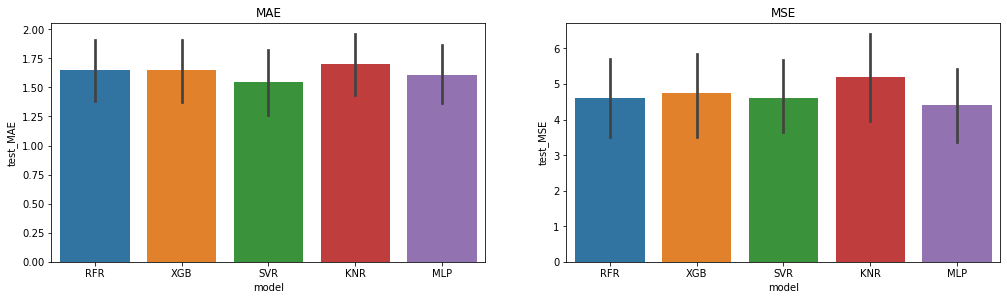

In [26]:
vizualization_metrics(df_scores_ste)

In [49]:
mse_models_steps = []
std_models_steps = []
for base in bases_all:
    print(base[0])
    cross_model = cross_val_score(base[1], x, y_ste, scoring='neg_mean_squared_error', cv=10)
    print("MSE: %0.3f, STD: %0.3f" % (-cross_model.mean(), cross_model.std()))
    mse_models_steps.append(-cross_model.mean())
    std_models_steps.append(cross_model.std())

KNR
MSE: 5.199, STD: 1.961
RFR
MSE: 4.615, STD: 1.758
SVR
MSE: 4.617, STD: 1.716
XGB
MSE: 4.752, STD: 1.856


In [50]:
MSE_models_no_opt_ste = pd.DataFrame(zip(names, mse_models_steps, std_models_steps), 
                                     columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models_no_opt_ste

,MODEL,MSE,STD
1,RFR,4.615319,1.757502
2,SVR,4.616831,1.715511
3,XGB,4.752484,1.855658
0,KNR,5.199048,1.961407


In [51]:
MSE_models_no_opt_ste.to_csv('df_models_steps_out.txt', index=None, sep=' ', mode='a')

# Hyperparametric optimization

### Groups

In [29]:
#KNR
start = time.time()
params = {'n_neighbors' : [10, 15, 20], 
          'weights': ['uniform', 'distance'], 
          'p':[1,2],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
search = GridSearchCV(KNR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_KNR = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_KNR.best_score_)
print('Best Hyperparameters: %s' % results_KNR.best_params_) #sorted(clf.cv_results_.keys())
print("%0.3f min"%((time.time()-start)/60))
knr_std = return_std(results_KNR)

Best MSE: 0.699
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
0.245 min
Best STD: 0.1294


In [30]:
#RFR
start = time.time()
params = { 'max_depth': [5, 8, 15, 20],
           'n_estimators': [50, 100, 300, 400]}
search = GridSearchCV(RFR, params,scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_RFR = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_RFR.best_score_)
print('Best Hyperparameters: %s' % results_RFR.best_params_)
print("%0.3f min"%((time.time()-start)/60))
rfr_std = return_std(results_RFR)

Best MSE: 0.677
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 300}
2.172 min
Best STD: 0.1328


In [31]:
#SVR
start = time.time()
params = {'C': [0.01, 0.1, 1.0, 5], 
          'epsilon': [0.01, 0.1, 0.5, 1.0, 5.0]} 
search = GridSearchCV(SV, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_SVR = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_SVR.best_score_)
print('Best Hyperparameters: %s' % results_SVR.best_params_)
print("%0.3f min"%((time.time()-start)/60))
svr_std = return_std(results_SVR)

Best MSE: 0.678
Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1}
2.665 min
Best STD: 0.1260


In [32]:
#XGB
start = time.time()
params = { 'max_depth': [3, 6, 10], 
           'learning_rate': [0.01, 0.1, 0.5],
           'n_estimators': [50, 75, 100]}
search = GridSearchCV(XGB, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_XGB = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_XGB.best_score_)
print('Best Hyperparameters: %s' % results_XGB.best_params_)
print("%0.3f min"%((time.time()-start)/60))
xgb_std = return_std(results_XGB)

Best MSE: 0.676
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
20.621 min
Best STD: 0.1322


In [295]:
#MLP
neurons = (8, 12, 16)
layers = []
for i in range(1,4):
    layers = layers +[x for x in itertools.product(neurons,repeat=i)]
    
start = time.time()
params = {'hidden_layer_sizes': layers}
search = GridSearchCV(MLP, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_MLP = search.fit(x, y_bin)
print('Best MSE: %0.3f' % -results_MLP.best_score_)
print('Best Hyperparameters: %s' % results_MLP.best_params_)
print("%0.3f min"%((time.time()-start)/60))
mlp_std = return_std(results_MLP)

Best MSE: 0.652
Best Hyperparameters: {'hidden_layer_sizes': (16, 8)}
2.503 min
Best STD: 0.1121


- ALL

In [34]:
mse_all = [-results_KNR.best_score_, -results_RFR.best_score_, -results_SVR.best_score_,
          -results_XGB.best_score_] #, -results_MLP.best_score_
std_all = [knr_std,  rfr_std, svr_std, xgb_std]
MSE_models = pd.DataFrame(zip(names, mse_all, std_all), columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models

,MODEL,MSE,STD
3,XGB,0.675538,0.132249
1,RFR,0.677155,0.132793
2,SVR,0.677733,0.125969
0,KNR,0.699461,0.129362


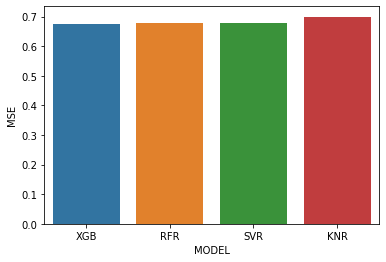

In [35]:
g = sns.barplot(x='MODEL', y='MSE', data=MSE_models)

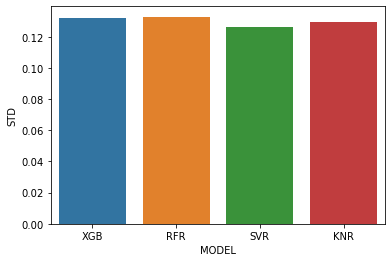

In [36]:
g = sns.barplot(x='MODEL', y='STD', data=MSE_models)

In [37]:
MSE_models.to_csv('df_optimized_models_out.txt', index=None, sep=' ', mode='a')

### Steps

In [38]:
#KNR
start = time.time()
params = {'n_neighbors' : [15, 25, 50, 75], 
          'weights': ['uniform', 'distance'], 
          'p':[1,2],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
search = GridSearchCV(KNR, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_KNR_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_KNR_steps.best_score_)
print('Best Hyperparameters: %s' % results_KNR_steps.best_params_) 
print("%0.3f min"%((time.time()-start)/60))
knr_std_steps = return_std(results_KNR_steps)

Best MSE: 4.547
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 50, 'p': 2, 'weights': 'distance'}
0.364 min
Best STD: 1.7361


In [39]:
#RFR
start = time.time()
params = { 'max_depth': [5, 8, 15, 20],
           'n_estimators': [50, 100, 300, 400]}
search = GridSearchCV(RFR, params,scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_RFR_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_RFR_steps.best_score_)
print('Best Hyperparameters: %s' % results_RFR_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
rfr_std_steps = return_std(results_RFR_steps)

Best MSE: 4.462
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 300}
2.212 min
Best STD: 1.7083


In [40]:
#SVR
start = time.time()
params = {'C': [0.01, 0.1, 1.0, 5], 
          'epsilon': [0.01, 0.1, 0.5, 1.0, 5.0]} 
search = GridSearchCV(SV, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_SVR_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_SVR_steps.best_score_)
print('Best Hyperparameters: %s' % results_SVR_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
svr_std_steps = return_std(results_SVR_steps)

Best MSE: 4.509
Best Hyperparameters: {'C': 1.0, 'epsilon': 1.0}
2.888 min
Best STD: 1.6980


In [41]:
#XGB
start = time.time()
params = { 'max_depth': [3, 6, 9],
           'learning_rate': [0.01, 0.1, 0.5],
           'n_estimators': [10, 20, 30]} # 'colsample_bytree': [0.4, 0.8, 1]
search = GridSearchCV(XGB, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
results_XGB_steps = search.fit(x, y_ste)
print('Best MSE: %0.3f' % -results_XGB_steps.best_score_)
print('Best Hyperparameters: %s' % results_XGB_steps.best_params_)
print("%0.3f min"%((time.time()-start)/60))
xgb_std_steps = return_std(results_XGB_steps)
# mse 4.786904, std 1.750987

Best MSE: 4.498
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30}
5.292 min
Best STD: 1.7314


- ALL

In [42]:
mse_all_steps = [-results_KNR_steps.best_score_, -results_RFR_steps.best_score_, -results_SVR_steps.best_score_,
                -results_XGB_steps.best_score_]
std_all_steps = [knr_std_steps,  rfr_std_steps, svr_std_steps, xgb_std_steps]
MSE_models_steps = pd.DataFrame(zip(names, mse_all_steps, std_all_steps), columns=['MODEL', 'MSE', 'STD']).sort_values(['MSE'])
MSE_models_steps

,MODEL,MSE,STD
1,RFR,4.462093,1.708304
3,XGB,4.498328,1.731417
2,SVR,4.509397,1.698026
0,KNR,4.547392,1.736121


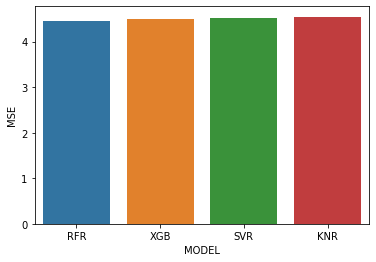

In [43]:
g = sns.barplot(x='MODEL', y='MSE', data=MSE_models_steps)

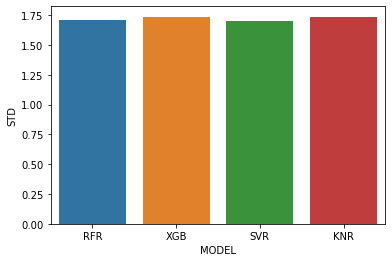

In [44]:
g = sns.barplot(x='MODEL', y='STD', data=MSE_models_steps)

In [45]:
MSE_models_steps.to_csv('df_optimized_models_steps_out.txt', index=None, sep=' ', mode='a')

# Group

In [53]:
MSE_models_no_opt = pd.read_csv('df_models_out.txt', sep=' ')
MSE_models = pd.read_csv('df_optimized_models_out.txt', sep=' ')

In [54]:
MSE_models['opt'] = 'optimized'
MSE_models_no_opt['opt'] = 'non-optimized'
frames = [MSE_models, MSE_models_no_opt]
df_models = pd.concat(frames)

In [55]:
df_models

,MODEL,MSE,STD,opt
0,XGB,0.675538,0.132249,optimized
1,RFR,0.677155,0.132793,optimized
2,SVR,0.677733,0.125969,optimized
3,KNR,0.699461,0.129362,optimized
0,SVR,0.685232,0.127521,non-optimized
1,RFR,0.699929,0.134300,non-optimized
2,XGB,0.717096,0.147209,non-optimized
3,KNR,0.789261,0.145815,non-optimized


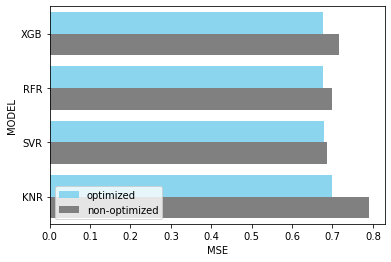

In [56]:
#sns.set(rc={'figure.figsize':(10,4)})
color2 = ['#7BDDFF', 'grey']
ax = sns.barplot(x="MSE", y="MODEL", hue="opt", data=df_models, palette=color2) 
#plt.title('MSE of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

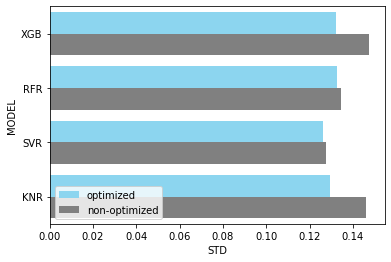

In [57]:
#sns.set(rc={'figure.figsize':(10,4)})
ax = sns.barplot(x="STD", y="MODEL", hue="opt", data=df_models, palette=color2)
#plt.title('STD of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

# Steps

In [58]:
MSE_models_no_opt_steps = pd.read_csv('df_models_steps_out.txt', sep=' ')
MSE_models_steps = pd.read_csv('df_optimized_models_steps_out.txt', sep=' ')

In [59]:
MSE_models_steps['opt'] = 'optimized'
MSE_models_no_opt_steps['opt'] = 'non-optimized'
frames_steps = [MSE_models_steps, MSE_models_no_opt_steps]
df_models_steps = pd.concat(frames_steps)

In [60]:
df_models_steps

,MODEL,MSE,STD,opt
0,RFR,4.462093,1.708304,optimized
1,XGB,4.498328,1.731417,optimized
2,SVR,4.509397,1.698026,optimized
3,KNR,4.547392,1.736121,optimized
0,RFR,4.615319,1.757502,non-optimized
1,SVR,4.616831,1.715511,non-optimized
2,XGB,4.752484,1.855658,non-optimized
3,KNR,5.199048,1.961407,non-optimized


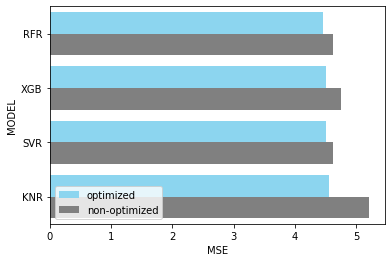

In [61]:
#sns.set(rc={'figure.figsize':(10,4)})
ax = sns.barplot(x="MSE", y="MODEL", hue="opt", data=df_models_steps, palette=color2) 
#plt.title('MSE of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')

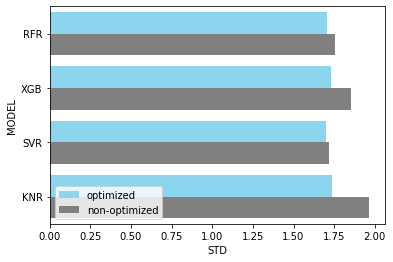

In [62]:
ax = sns.barplot(x="STD", y="MODEL", hue="opt", data=df_models_steps, palette=color2)
#plt.title('STD of single models with optimalization and without opt.', fontsize=15)
plt.legend(loc='lower left')